# Tutorial

## Preliminaries

The following set of examples shows the user how to train a Masked Autoregressive Flow (MAF) and an example Kernel Density Estimator (KDE). We further demonstrate how to use `margarine` to estimate the Kullback Leibler divergence and Bayesian Dimensionality with the trained MAF and KDE.

The code requires [anesthetic](https://pypi.org/project/anesthetic/) to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic.samples import NestedSamples

In order to demonstrate the applications of the code we need to load some example samples from a nested sampling run and we can visualise the posterior distributions with `anesthetic`. We write a helper function to load the chains and transform the parameters in the first three columns, which were generated with a log-uniform prior, into the unifrom parameter space.

`margarine` currently assumes that the parameters are uniformly distributed when calculating the KL divergence and bayesian dimensionality. It is therefore important to transform the parameters into the uniform parameter space before we train our MAF and KDE.

In [2]:
def load_chains(root):
    """
    Function uses anesthetic to load in a set of chains and returns
    the pandas table of samples, a numpy
    array of the parameters in the uniform space and weights.
    """

    samples = NestedSamples(root=root)

    try:
        names = ['p' + str(i) for i in range(ndims)]
        theta = samples[names].values
    except:
        names = [i for i in range(ndims)]
        theta = samples[names].values

    weights = samples.weights

    return samples, theta, weights

ndims=5

root = '../tests/test_samples/test'
samples, theta, weights = load_chains(root)


To visualise the posterior we define another helper function that will be useful later in the notebook.

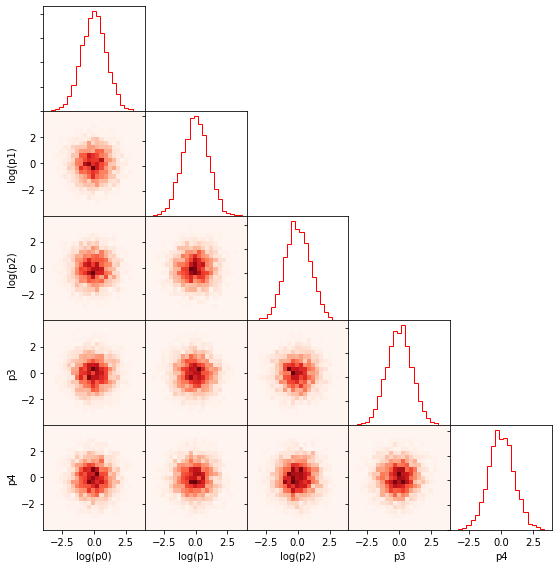

In [3]:
from anesthetic.plot import hist_plot_1d, hist_plot_2d

def plotter(theta, names, w=None, ndims=5):
    """ Helper function that uses anesthetic to produce corner plots """
    fig, axes = plt.subplots(ndims, ndims, figsize=(8, 8), sharex='col')
    for i in range(ndims):
        for j in range(ndims):
            if i < j:
                axes[i, j].axis('off')
            if i == j:
                hist_plot_1d(axes[i, j], theta[:, i], weights=w,
                xmin=theta[:, i].min(), xmax=theta[:, i].max(), color='r',
                histtype='step', bins=25, density=True)
            if i < j:
                hist_plot_2d(axes[j, i], theta[:, i], theta[:, j],
                            weights=w,
                            xmin=theta[:, i].min(), xmax=theta[:, i].max(),
                            ymin=theta[:, j].min(), ymax=theta[:, j].max(),
                            bins=25, density=True, cmap=plt.get_cmap('Reds'))
            if j not in set([0, ndims]):
                axes[i, j].set_yticklabels([])
            if j == 0:
                if i == 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(names[i])
            if i == ndims-1:
                axes[i, j].set_xlabel(names[j])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

names = ['log(p' + str(i) + ')' if i in [0, 1, 2] else 'p' + str(i) for i in range(ndims)]
plotter(theta, names, weights)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `margarine`. To train the MAF we first need to initalise the class with the samples and corresponding weights.

In [4]:
import os
os.chdir('../')

from margarine.maf import MAF

bij = MAF(theta, weights)
bij.train(100)

Epoch: 0 Loss: 0.0007185101
Epoch: 1 Loss: 0.0007014023
Epoch: 2 Loss: 0.0006839341
Epoch: 3 Loss: 0.00066634326
Epoch: 4 Loss: 0.0006487031
Epoch: 5 Loss: 0.00063104363
Epoch: 6 Loss: 0.0006133788
Epoch: 7 Loss: 0.0005957194
Epoch: 8 Loss: 0.00057807605
Epoch: 9 Loss: 0.000560463
Epoch: 10 Loss: 0.00054290093
Epoch: 11 Loss: 0.00052541785
Epoch: 12 Loss: 0.0005080515
Epoch: 13 Loss: 0.00049085025
Epoch: 14 Loss: 0.00047387503
Epoch: 15 Loss: 0.00045719987
Epoch: 16 Loss: 0.0004409128
Epoch: 17 Loss: 0.00042511517
Epoch: 18 Loss: 0.00040991933
Epoch: 19 Loss: 0.00039544463
Epoch: 20 Loss: 0.00038181068
Epoch: 21 Loss: 0.00036913107
Epoch: 22 Loss: 0.0003575051
Epoch: 23 Loss: 0.00034701102
Epoch: 24 Loss: 0.00033769925
Epoch: 25 Loss: 0.00032958362
Epoch: 26 Loss: 0.0003226317
Epoch: 27 Loss: 0.00031675794
Epoch: 28 Loss: 0.00031182577
Epoch: 29 Loss: 0.0003076632
Epoch: 30 Loss: 0.00030409006
Epoch: 31 Loss: 0.00030094603
Epoch: 32 Loss: 0.00029811086
Epoch: 33 Loss: 0.00029550795
Epo

We can then generate samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

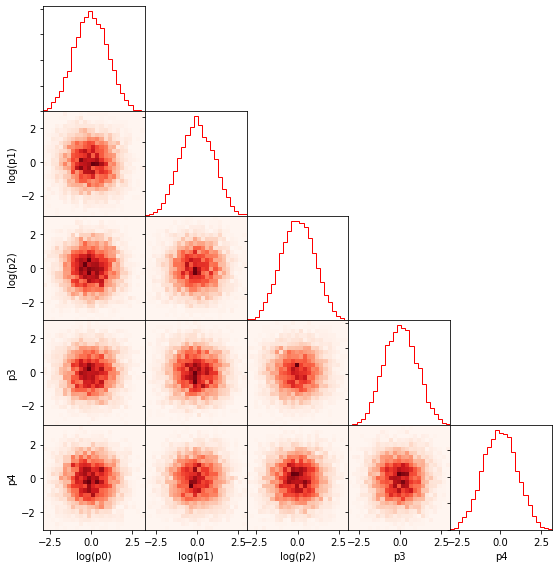

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(theta), theta.shape[-1])))

plotter(x, names)

Alternatively we can generate samples with the following code which takes in an integer and returns an array of shape (int, 5). The `.sample()` function is a proxy for `__call__`.

In [6]:
x = bij.sample(5000)

We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. 

The samples presented here were generated using a gaussian likelihood and fitting with nested sampling for 5 parameters. We can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for the samples for comparison. We see very similar results and note that the similarity improves with the number of epochs.

In [7]:
from margarine.marginal_stats import maf_calculations

stats = maf_calculations(bij, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

tf.Tensor(3.2990043, shape=(), dtype=float32) 3.3308079438366938
tf.Tensor(4.3727474, shape=(), dtype=float32) 5.013952162478263


We could imagine that the above set of parameters is a sub-sample of perhaps signal parameters that we are interested in and having marginalised out the nuisance parameters we can use `margarine` to determine how well constrained the sub-space is.

As an example we can train a MAF on three of the parameters in this distribution.

Epoch: 0 Loss: 0.00043151045
Epoch: 1 Loss: 0.00041672972
Epoch: 2 Loss: 0.00040160108
Epoch: 3 Loss: 0.0003863657
Epoch: 4 Loss: 0.00037109375
Epoch: 5 Loss: 0.00035581551
Epoch: 6 Loss: 0.00034055865
Epoch: 7 Loss: 0.0003253689
Epoch: 8 Loss: 0.00031032556
Epoch: 9 Loss: 0.000295559
Epoch: 10 Loss: 0.00028127024
Epoch: 11 Loss: 0.00026773606
Epoch: 12 Loss: 0.0002552729
Epoch: 13 Loss: 0.0002441286
Epoch: 14 Loss: 0.00023431709
Epoch: 15 Loss: 0.00022553187
Epoch: 16 Loss: 0.00021728151
Epoch: 17 Loss: 0.00020923858
Epoch: 18 Loss: 0.00020157515
Epoch: 19 Loss: 0.0001947428
Epoch: 20 Loss: 0.00018895789
Epoch: 21 Loss: 0.00018402831
Epoch: 22 Loss: 0.00017959857
Epoch: 23 Loss: 0.00017541902
Epoch: 24 Loss: 0.00017139025
Epoch: 25 Loss: 0.0001674916
Epoch: 26 Loss: 0.00016375972
Epoch: 27 Loss: 0.00016028345
Epoch: 28 Loss: 0.0001571421
Epoch: 29 Loss: 0.00015434317
Epoch: 30 Loss: 0.0001518309
Epoch: 31 Loss: 0.00014954529
Epoch: 32 Loss: 0.00014746259
Epoch: 33 Loss: 0.00014559379


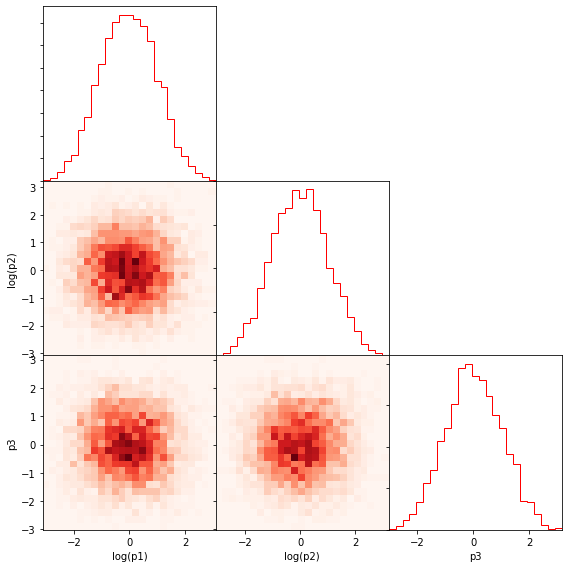

tf.Tensor(1.9784489, shape=(), dtype=float32)
tf.Tensor(2.5428524, shape=(), dtype=float32)


In [8]:
theta_reduced = theta[:, 1:-1]
names_reduced = names[1:-1]

bij = MAF(theta_reduced, weights)
bij.train(100)
x = bij.sample(5000)

plotter(x, names_reduced, ndims=3)

stats = maf_calculations(bij, x)
print(stats.klDiv())
print(stats.bayesian_dimensionality())

# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

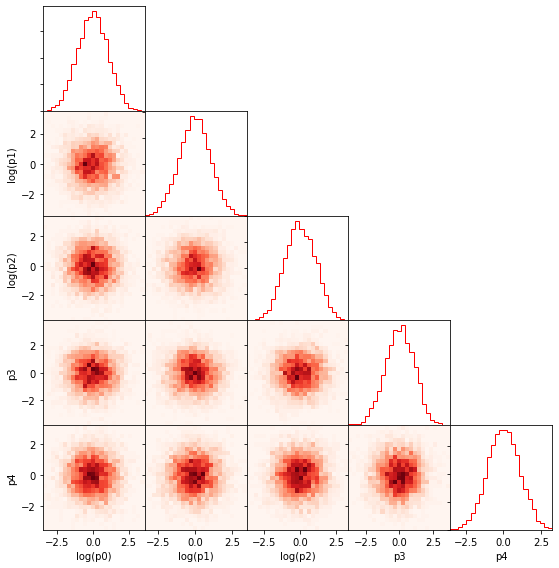

tf.Tensor(3.1492083, shape=(), dtype=float32) 3.3308079438366938
tf.Tensor(4.025139, shape=(), dtype=float32) 5.013952162478263


In [9]:
from margarine.kde import KDE
kde = KDE(theta, weights)
kde.generate_kde()
x = kde.sample(5000)

plotter(x, names)

from margarine.marginal_stats import kde_calculations

stats = kde_calculations(kde, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

Rather than using the `kde.sample()` function to generate samples we could transform samples from the hypercube with the following code and the `__call__()` function. However, we note that this is a much slower method of generating samples as it is designed to be bijective. Transformation from the hypercube is useful if we would like to use a trained KDE or MAF as the prior in a subseqeunt nested sampling run however is not necessary if we simply want to calcualte marginal Bayesian statistics.

In [10]:
x = kde(np.random.uniform(0, 1, size=(10, theta.shape[-1])))
print(x)

[[-2.30580893  0.2615454   1.0305738   0.95230235 -0.9160518 ]
 [ 0.449536   -0.21128596  0.37450897 -0.06924562 -0.1435756 ]
 [-0.23842612  1.89020679  1.01175275 -0.79411737 -1.26997843]
 [ 0.69827796 -0.85031383  0.12800782  1.87217983 -0.0720315 ]
 [-1.96867173 -1.70556795 -0.56749216 -1.02797262 -0.87023201]
 [-0.55155518 -0.60825292  1.81532878 -1.32111645  0.61482667]
 [-0.8416832   0.18485707  2.00253196  0.49622835 -0.63868005]
 [-0.52705685 -0.11567092 -1.41513758 -1.26160741 -0.94664933]
 [ 0.87743055  2.28065551 -0.94326398 -1.12061011 -0.03694226]
 [ 0.39296398  0.62991565  1.31726872  0.46559934 -0.55856522]]
